In [6]:
from __future__ import print_function

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [36]:
class MLP:
    '''
    Implementation of Multi-Layer Perceptron from scratch
    '''
    def __init__(self, h_units, h_acti='relu'):
        '''
        h_units: number of hidden units as a list
        h_acti: hidden activation ('relu' or 'sigmoid')
        '''
        self.h_units = h_units
        self.h_acti = h_acti

    def hidden_acti(self, x):
        '''
        return hidden activation of x
        '''
        if self.h_acti == 'relu':
            return (x>0)*x
        elif self.h_acti == 'sigmoid':
            return 1/(1+np.exp(-x))
        else:
            return x
    
    def output_acti(self, x):
        '''
        return output activation of x
        '''
        if self.K == 1:
            return 1/(1+np.exp(-x))
        else:
            x_e = np.exp(x - np.max(x, axis=0, keepdims=True))
            return x_e / np.sum(x_e, axis=0)

    def feed_forward(self, X):
        '''
        return the outputs of all layer as a list
        '''
        a = [X]
        for i in range(len(self.h_units) + 1):
            z = np.matmul(self.W[i].T, a[i])
            # output layer
            if i == len(self.h_units):
                a.append(self.output_acti(z))
            else:
                a.append(self.hidden_acti(z))
                N = a[-1].shape[1]
                a[-1] = np.vstack((np.ones((1, N)), a[-1]))
        return a
    
    def predict(self, X):
        '''
        return output of the last layer
        '''
        X = np.vstack((np.ones((1, X.shape[-1])), X))
        return self.feed_forward(X)[-1]

    def weight_init(self):
        '''
        initialize weights from N(0,1), and zero biases 
        '''
        self.W = []
        iDim = self.M
        n_units = self.h_units + [self.K]
        for n in n_units:
            self.W.append(np.vstack((np.zeros((1,n)), np.random.randn(iDim, n))))
            iDim = n

    def loss(self, y, p, lamb=0):
        '''
        compute loss
        '''
        eps = 1e-9
        N = y.shape[-1]
        if self.K == 1:
            J = np.mean(-y*np.log(np.maximum(p,eps)) - (1-y)*np.log(np.maximum(1-p,eps)))
        else:
            J = np.sum(-y*np.log(np.maximum(p,eps))) / N
        
        # regularization term
        if lamb != 0:
            for w in self.W:
                J += lamb*np.sum(w[1:,:]**2)# exclude bias
        return J

    def act_grad(self, h):
        '''
        compute gradient of activation function
        '''
        if self.h_acti == 'relu':
            return (h>0)*.1
        elif self.h_acti == 'sigmoid':
            return h*(1-h)

    def fit(self, X, y, max_iters=1e4, lamb=0, step_size=0.01):
        '''
        learn MLP weights and biases using MLE
        X: n_features x n_examples
        y: [n_examples] (categorial coding), or [K x n_examples] (one hot coding of K classes)
        lamb: (l2) regularization parameter
        step_size: learning rate
        '''
        self.M, N = X.shape
        X = np.vstack((np.ones((1,N)), X))

        assert N == y.shape[-1], 'number of samples and labels are different'
        
        y = y - np.min(y)
        self.K = int(np.max(y)+1)
        if y.ndim == 1: # encode as one hot
            if np.unique(y).size != 2:
                y_onehot = np.eye(self.K)[:,y.astype(np.int)]
            else:
                y_onehot = y[np.newaxis,:]
                self.K = 1
        
        # initialize weights, biases
        self.weight_init()
        L = len(self.h_units) + 2 # number of layers

        # training
        for i in range(int(max_iters)):
            # feed forward
            a = self.feed_forward(X)
            p = a[-1]

            # compute loss
            E = self.loss(y_onehot, p, lamb)
            Pr = np.argmax(p, axis=0)
            if (i+1) % int(max_iters/10) == 0:
                print('Iter: %d ===== Loss: %.4f ===== Acc: %.2f' % (i+1, E, np.mean(Pr==y)*100))

            # back propagate errors
            Delta = [] # used to update weights and biases
            for l in range(L-2, -1, -1):
                if l == L-2:
                    # compute sigma for the output layer
                    sigma = p-y_onehot
                else:
                    sigma = np.matmul(self.W[l+1][1:,], sigma)*self.act_grad(a[l+1][1:,:])

                d = np.matmul(a[l], sigma.T)/N
                if lamb != 0:
                    d[1:,:] = d[1:,:]/N +  lamb*self.W[l][1:,:] # l2 regularization on weights
                    d[0,:] = d[0,:]/N
                else:
                    d = d/N
                Delta = [d] + Delta
            
            # update weights and biases
            for l in range(len(self.W)):
                self.W[l] -= step_size*Delta[l]

In [37]:
def test_syn_db():
    # generate synthetic data
    N = 100
    C = 3
    X = np.zeros((N*C, 2))
    y = np.zeros(N*C, dtype=np.uint8)
    for j in range(C):
        ix = range(N*j,N*(j+1))
        r = np.linspace(0.0,1,N) # radius
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    X = X.T # data matrix (each column = single example)

    # fit mlp on X
    mlp = MLP([500], 'relu')
    mlp.fit(X, y, max_iters=1e5, lamb=0.00001, step_size=0.1) # using l2 regularization

    # plot
    plt.plot(X[0,y==0], X[1,y==0], 'o', color='red')
    plt.plot(X[0,y==1], X[1,y==1], 'o', color='green')
    plt.plot(X[0,y==2], X[1,y==2], 'o', color='blue')
    xx, yy = np.meshgrid(np.arange(-1.5, 1.5, 0.1), np.arange(-1.5, 1.5, 0.1))
    test_X = np.vstack((xx.ravel(), yy.ravel()))
    test_p = mlp.predict(test_X).argmax(axis=0)
    plt.contour(xx, yy, test_p.reshape(xx.shape), colors=['red', 'green', 'blue'])
    plt.show()

Iter: 10000 ===== Loss: 0.3420 ===== Acc: 89.00
Iter: 20000 ===== Loss: 0.2140 ===== Acc: 97.00
Iter: 30000 ===== Loss: 0.1727 ===== Acc: 97.67
Iter: 40000 ===== Loss: 0.1504 ===== Acc: 98.00
Iter: 50000 ===== Loss: 0.1361 ===== Acc: 98.67
Iter: 60000 ===== Loss: 0.1262 ===== Acc: 98.67
Iter: 70000 ===== Loss: 0.1190 ===== Acc: 98.67
Iter: 80000 ===== Loss: 0.1134 ===== Acc: 98.67
Iter: 90000 ===== Loss: 0.1090 ===== Acc: 98.67
Iter: 100000 ===== Loss: 0.1054 ===== Acc: 98.67


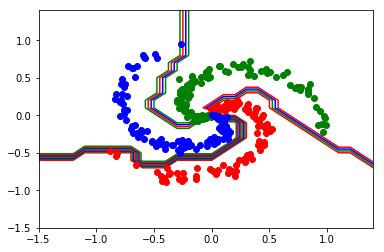

In [38]:
test_syn_db()

In [44]:
def test_mnist():
    # download mnist 784
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
    # shuffle data
    random_state = check_random_state(0)
    permutation = random_state.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    X = X.reshape((X.shape[0], -1))
    # split into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=5000, test_size=5000) # using 5000 labeled examples for training
    X_train = X_train.T
    X_test = X_test.T
    y_train = y_train.astype(np.uint8)
    y_test = y_test.astype(np.uint8)
    # fit mlp on X_train
    mlp = MLP([500,100], 'relu')
    mlp.fit(X_train, y_train, max_iters=1e3, step_size=0.1)
    # test mlp on X_test
    Pr = mlp.predict(X_test).argmax(axis=0)
    print('\nTest Acc: %.2f' % (np.mean(Pr==y_test)*100))

In [45]:
test_mnist()

Iter: 100 ===== Loss: 6.9589 ===== Acc: 66.42
Iter: 200 ===== Loss: 5.4254 ===== Acc: 73.82
Iter: 300 ===== Loss: 4.8067 ===== Acc: 76.80
Iter: 400 ===== Loss: 4.8492 ===== Acc: 76.60
Iter: 500 ===== Loss: 4.1177 ===== Acc: 80.12
Iter: 600 ===== Loss: 3.9664 ===== Acc: 80.86
Iter: 700 ===== Loss: 3.4235 ===== Acc: 83.48
Iter: 800 ===== Loss: 3.6722 ===== Acc: 82.28
Iter: 900 ===== Loss: 3.3380 ===== Acc: 83.88
Iter: 1000 ===== Loss: 3.2204 ===== Acc: 84.46

Test Acc: 79.74
